In [1]:
# Library
import pandas as pd
from pandas import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, shapiro, chi2, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from itertools import product
import seaborn as sns
from scipy.stats import skew, kurtosis
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from pyproj import Transformer
from statsmodels.stats.diagnostic import normal_ad

In [2]:
"""FUNCTIONS"""
#Uji Kestasioneran Data
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value from the ADF test

# STACF (Pfeifer and Deutsch)
def Gamma_estimate(s,Z):
    Gs = [[0 for j in range(len(Z))] for i in range(len(Z))]
    for i in range(len(Z.columns)-s):
        a = Z.iloc[:,i].to_numpy().reshape((len(Z),1))
        b = Z.iloc[:,i+s].to_numpy().reshape((1,len(Z)))
        Gs += np.matmul(a,b)/(len(Z.columns)-s)
    return Gs

def gamma_estimate(l,k,s,W,Z):
    if s >= 0:
        gs = np.matmul(np.matmul(np.transpose(W[k]),W[l]),
        Gamma_estimate(s,Z))/len(Z)
    else:
        gs = np.matmul(np.matmul(np.transpose(W[l]),W[k]),
        Gamma_estimate(-s,Z))/len(Z)
    return np.trace(gs)

def STACF(s,W,Z):
    STACF = [[0 for j in range(s)] for i in range(len(W))]
    for i in range(len(W)):
        for j in range(s):
            a = gamma_estimate(i,0,j,W,Z)
            b = gamma_estimate(i,i,0,W,Z)
            c = gamma_estimate(0,0,0,W,Z)
            STACF[i][j] = a/np.sqrt(b*c)
    return STACF

# STPACF (Pfeifer and Deutsch)
def STPACF(s,W,Z):
    Y = []
    for i in range(s):
        for j in range(len(W)):
            Y.append(gamma_estimate(j,0,i+1,W,Z))
    X = []
    for k in range(s):
        for l in range(len(W)):
            u = []
            for m in range(s):
                for n in range(len(W)):
                    u.append(gamma_estimate(l,n,k-m,W,Z))
            X.append(u)
    X_inv = np.linalg.inv(X)
    Z = np.matmul(X_inv,Y)
    A = [[0 for i in range(s)] for j in range(len(W))]
    j = 0
    k = 0
    for i in range(len(Z)):
        if (i+1)%len(W) != 0:
            A[j][k] = Z[i]
            j += 1
        else:
            A[j][k] = Z[i]
            j = 0
            k += 1
    return A

def plot_acf(timelag, variable_data, W, data_train, ylabel, title_prefix='Spatial Lag', confidence_level=1.96):
    #Parameters:
    #- timelag: List or array of time lags
    #- variable_data: List or 2D array of the data for which ACF is to be plotted (e.g., STACF values)
    #- W: Spatial weight matrix
    #- data_train: Training data for setting the confidence bounds
    #- ylabel: Label for the y-axis (default 'STACF')
    #- title_prefix: Title prefix for each subplot (default 'Spatial Lag')
    #- confidence_level: Confidence level for the red horizontal lines (default 1.96)
    
    #Returns:
    #- Displays the plots of the ACF for each spatial lag.
    plt.rcParams["figure.figsize"] = (20, 15)
    figure, axis = plt.subplots(int(np.ceil(len(W) / 2)), 2)
    
    pos1 = 0
    for i in range(len(W)):
        end = False
        if i % 2 == 0:
            pos2 = 0
        else:
            pos2 = 1
            end = True

        axis[pos1][pos2].scatter(x=timelag, y=variable_data[i])
        axis[pos1][pos2].vlines(x=timelag, ymin=0, ymax=variable_data[i])
        axis[pos1][pos2].set_title(f'Spatial Lag {i}', fontsize=16)
        axis[pos1][pos2].set_ylim([pd.DataFrame(variable_data).min().min() - 0.1, pd.DataFrame(variable_data).max().max() + 0.1])
        axis[pos1][pos2].axhline(y=confidence_level / (len(data_train) * len(data_train.columns)) ** 0.5, linestyle="--", c="red")
        axis[pos1][pos2].axhline(y=-confidence_level / (len(data_train) * len(data_train.columns)) ** 0.5, linestyle="--", c="red")
        
        axis[pos1][pos2].set_ylabel(ylabel, fontsize=14)
        axis[pos1][pos2].grid()

        if end:
            pos1 += 1

    if len(W) % 2 == 1:
        figure.delaxes(axis[pos1][pos2 + 1])
    
    plt.show()

# Parameter Estimation
def V(i,k,t,W,Z):
    V = 0
    Zt = Z.to_numpy()
    Wk = W[k]
    for j in range(len(Z)):
        V += Wk[i][j]*Zt[j][t]
    return V

def Y(p,Z):
    Y = Z.iloc[:,p:]
    Y = Y.to_numpy()
    Y = Y.reshape((len(Z)*(len(Z.columns)-p),1))
    return Y

def Xi(i,p,sp_or,W,Z):
    X = []
    for f in range(p-1,len(Z.columns)-1):
        u = []
        for g in range(p):
            for h in range(sp_or[g]+1):
                u.append(V(i,h,f-g,W,Z))
        X.append(u)
    return np.array(X)

def X(p,sp_or,W,Z):
    Xi_list = []
    for i in range(len(Z)):
        Xi_list.append(Xi(i,p,sp_or,W,Z))
    a = len(Z.columns)- p
    b = p + np.sum(sp_or)
    zeros = np.zeros((a,b))
    X = [[zeros for j in range(len(Xi_list))] for i in range(len(Xi_list))]
    for j in range(len(Xi_list)):
        X[j][j] = Xi_list[j]
    return np.block(X)

def GSTAR(p,sp_or,W,Z):
    global err
    global pred
    global est
    global result
    Ys = Y(p,Z)
    Xs = X(p,sp_or,W,Z)
    XTX_inv = np.linalg.inv(Xs.T@Xs)
    est = XTX_inv@Xs.T@Ys
    Par = []
    for i in range(p):
        for j in range(sp_or[i]+1):
            for k in range(len(Z)):
                Par.append(r"$\phi_{"+str(i+1)+str(j)+"}ˆ{("+str(k+1)+")}$")
    Par = np.array(Par).reshape((len(est),1))
    pred = Xs@est
    err = Ys- pred
    SSE = (err.T)@err
    MSE = SSE/(len(Ys)-len(Xs[0]))
    se = np.array([(MSE[0]*XTX_inv[i][i])**0.5 for i in 
                   range(len(est))]).reshape((len(est),1))
    T = np.array([est[i]/(MSE[0]*XTX_inv[i][i])**0.5 for i in 
                  range(len(est))]).reshape((len(est),1))
    P = [0 for i in range(len(est))]
    sign = [0 for i in range(len(est))]
    for i in range(len(est)):
        if T[i] > 0:
            P[i] = 2*(1-t.cdf(T[i],len(Ys)-len(Xs[0])))
        else:
            P[i] = 2*(t.cdf(T[i],len(Ys)-len(Xs[0])))
        if P[i] < 0.05:
            sign[i] = 'Significant'
        else:
            sign[i] = 'Insignificant'
    P = np.array(P).reshape((len(est),1))
    sign = np.array(sign).reshape((len(est),1))
    result = pd.DataFrame({'Parameter' : Par.reshape(len(est)), 
                           'Estimate' : est.reshape(len(est)), 'Std. Error' : 
                           se.reshape(len(est)), 't Value' :T.reshape(len(est)), 'Pr > |t|' 
                           :P.reshape(len(est)), 'Significance' : 
                           sign.reshape(len(est))})
    MAPE = 0
    dev = 0
    for i in range(len(pred)):
        MAPE += np.abs(Ys[i]-pred[i])/np.abs(Ys[i])
        dev += np.abs(Ys[i]-np.mean(Ys))
    MASE = sum(np.abs(err))/dev
    AIC = (len(Ys)*np.log(MSE)+2*len(est))[0][0]
    return {
    "AIC": float(AIC),
    "RMSE": float(np.sqrt(MSE[0][0])),
    "MAPE": float(MAPE[0]*100/len(Ys)),
    "MASE": float(MASE[0]),
    "p": p,
    "sp_or": sp_or,
    "W_name": "W_corr" if W is W_corr else "W"
}

def auto_GSTAR(data_train, W_list):
    all_models = []
    N = len(W_list)-1  # Number of matrices

    for p in range(1, N + 1):  # Loop p from 1 to N
        sp_or_options = list(product(range(p + 1), repeat=p))  # combinations of length p from 0 to p

        for sp_or in sp_or_options:
            for W_matrix, W_name in zip([W, W_corr], ['W', 'W_corr']):
                try:
                    result = GSTAR(p, sp_or, W_matrix, data_train)
                    result["W_name"] = W_name
                    all_models.append(result)
                except Exception as e:
                    print(f"Model (p={p}, sp_or={sp_or}, W={W_name}) failed with error: {e}")

    # Find the model with the smallest AIC
    all_models_df = pd.DataFrame(all_models)
    best_model = all_models_df.loc[all_models_df['AIC'].idxmin()]

    return best_model, all_models_df


In [3]:
# Data Import
data = pd.read_excel(r"C:\Users\zrclm\Documents\Ezra\Kuliah\Tugas Akhir\Data DBD Kota Semarang\Data DBD 2016-2021 Kota Semarang Adjusted Format.xlsx"
                     , sheet_name="Sheet1")

data_diff = pd.read_excel(r"C:\Users\zrclm\Documents\Ezra\Kuliah\Tugas Akhir\Data DBD Kota Semarang\Data DBD 2016-2021 Kota Semarang Adjusted Format.xlsx"
                     , sheet_name="Diff")

# Data Preparation
Z = data.drop(['Location','Longitude','Latitude'], axis = 1)
Z_diff = data_diff.drop(['Location','Longitude','Latitude'], axis = 1)

ADF = data.drop(['Longitude','Latitude'], axis = 1)
ADF_diff = data_diff.drop(['Longitude','Latitude'], axis = 1)

data_train = Z_diff.iloc[:, :65]
data_testing = Z_diff.iloc[:, 65:]

C:\Users\zrclm\AppData\Local\Temp\ipykernel_29208\2361626486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Location', y='Value', data=df_melted, palette='Set1')


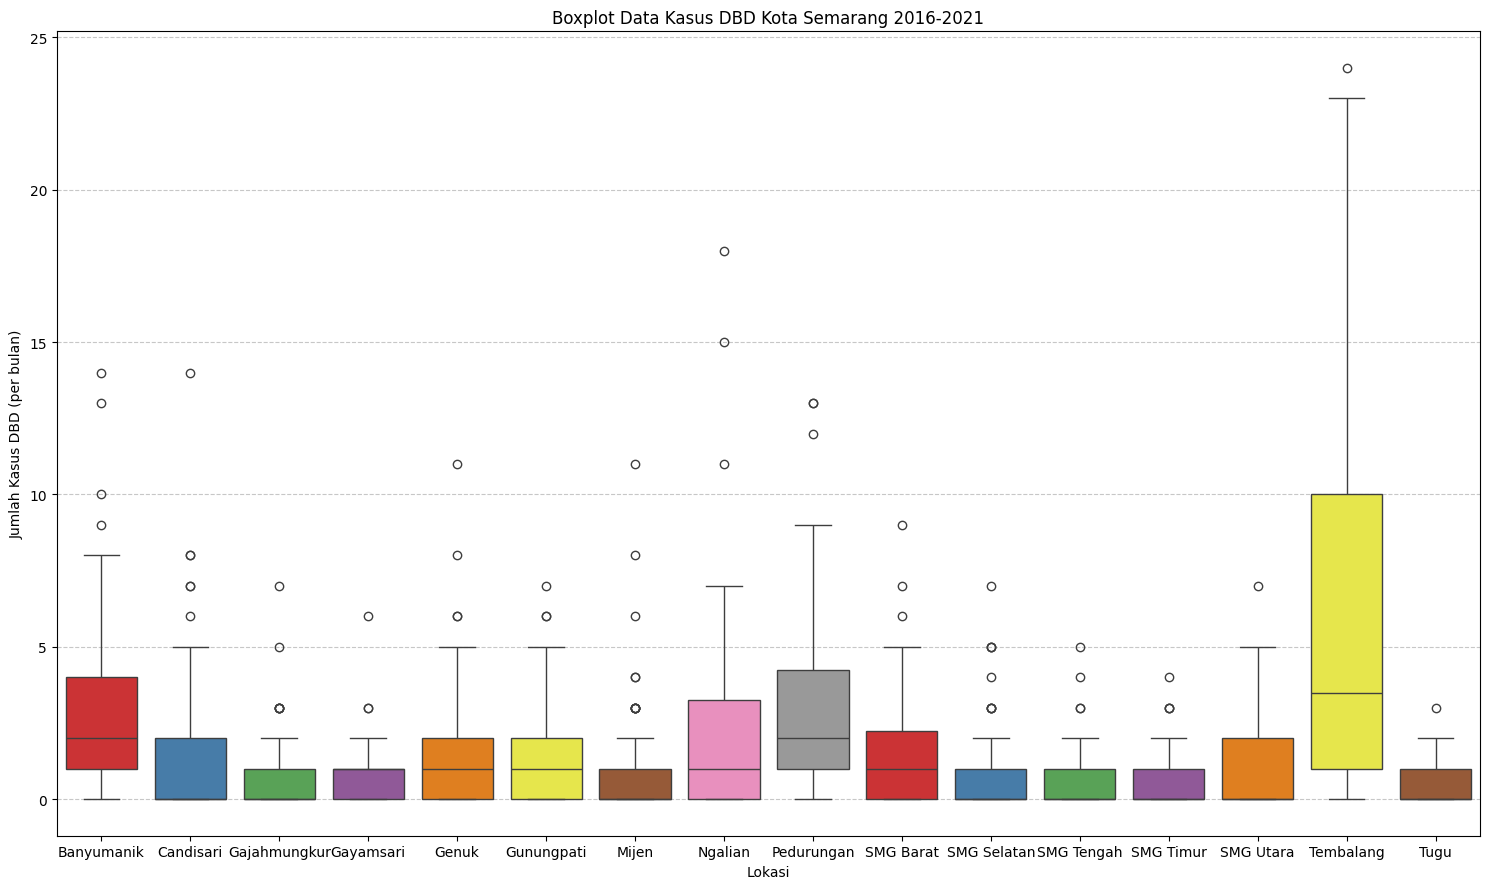

In [4]:

#Boxplot Data Simulasi
df_transposed = Z.T
df_melted = df_transposed.melt(var_name='Location', value_name='Value')
locations = data.iloc[:,0].values
df_transposed.columns = locations

# Melt the DataFrame for plotting
df_melted = df_transposed.melt(var_name='Location', value_name='Value')

# Create the boxplot
plt.figure(figsize=(15, 9))
sns.boxplot(x='Location', y='Value', data=df_melted, palette='Set1')
plt.title('Boxplot Data Kasus DBD Kota Semarang 2016-2021')
plt.xlabel('Lokasi')
plt.ylabel('Jumlah Kasus DBD (per bulan)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [1231]:
'''
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Create DataFrame
df_lokasi = pd.DataFrame(lokasi)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(df_lokasi['Lintang'], df_lokasi['Bujur'], color='green')

# Add labels to each point
for i in range(len(df_lokasi)):
    plt.text(df_lokasi['Lintang'][i] + 0.01, df_lokasi['Bujur'][i], df_lokasi['Kecamatan'][i], fontsize=9)

# Axis labels and title
plt.xlabel('Longitude (Lintang)')
plt.ylabel('Latitude (Bujur)')
plt.title('Koordinat 16 Kecamatan di Kota Semarang')
plt.grid(True)
plt.show()
'''

"\nlokasi = {\n    'Kecamatan': [\n        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',\n        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',\n        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'\n    ],\n    'Bujur': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    'Lintang': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Create DataFrame\ndf_lokasi = pd.DataFrame(lokasi)\n\n# Plotting\nplt.figure(figsize=(10, 8))\nplt.scatter(df_lokasi['Lintang'], df_lokasi['Bujur'], color='green')\n\n# Add labels to each point\nfor i in range(len(df_lokasi)):\n    plt.text(df_lokasi['Lintang'][i] + 0.01, df_lokasi['Bujur'][i],

In [1232]:
'''
# Define the data
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Create GeoDataFrame in EPSG:4326
df = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['Lintang'], df['Bujur'])],
    crs="EPSG:4326"
)

# Project to EPSG:3857 for contextily basemap
gdf_web = gdf.to_crs(epsg=3857)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 8))
gdf_web.plot(ax=ax, color='green', markersize=50)

# Add kecamatan labels
for x, y, label in zip(gdf_web.geometry.x, gdf_web.geometry.y, gdf_web['Kecamatan']):
    ax.text(x + 1000, y, label, fontsize=8)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)


# Set limits from data
# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Peta Lokasi Kecamatan di Semarang")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()
'''

'\n# Define the data\nlokasi = {\n    \'Kecamatan\': [\n        \'Banyumanik\', \'Candisari\', \'Gajahmungkur\', \'Gayamsari\', \'Genuk\', \'Gunungpati\',\n        \'Mijen\', \'Ngaliyan\', \'Pedurungan\', \'Semarang Barat\', \'Semarang Selatan\',\n        \'Semarang Tengah\', \'Semarang Timur\', \'Semarang Utara\', \'Tembalang\', \'Tugu\'\n    ],\n    \'Bujur\': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    \'Lintang\': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Create GeoDataFrame in EPSG:4326\ndf = pd.DataFrame(lokasi)\ngdf = gpd.GeoDataFrame(\n    df,\n    geometry=[Point(xy) for xy in zip(df[\'Lintang\'], df[\'Bujur\'])],\n    crs="EPSG:4326"\n)\n\n# Project to EPSG:3857 for contextily basema

In [1233]:
'''
p_values = {}
stasioner = []
non_stasioner = []

# Uji ADF untuk tiap lokasi
for index, row in ADF_diff.iterrows():
    location = row['Location']
    location_data = row[1:]  # data waktu


    adf_result = adfuller(location_data, maxlag=10, autolag="AIC",regression="c")
    p_value = adf_result[1]
    p_values[location] = p_value

    if p_value < 0.05:
        stasioner.append(location)
    else:
        non_stasioner.append(location)

pval_df = pd.DataFrame(list(p_values.items()), columns=['Location', 'p-value'])
pval_df = pval_df.sort_values('Location').reset_index(drop=True)
'''

'\np_values = {}\nstasioner = []\nnon_stasioner = []\n\n# Uji ADF untuk tiap lokasi\nfor index, row in ADF_diff.iterrows():\n    location = row[\'Location\']\n    location_data = row[1:]  # data waktu\n\n\n    adf_result = adfuller(location_data, maxlag=10, autolag="AIC",regression="c")\n    p_value = adf_result[1]\n    p_values[location] = p_value\n\n    if p_value < 0.05:\n        stasioner.append(location)\n    else:\n        non_stasioner.append(location)\n\npval_df = pd.DataFrame(list(p_values.items()), columns=[\'Location\', \'p-value\'])\npval_df = pval_df.sort_values(\'Location\').reset_index(drop=True)\n'

In [1234]:
'''
W = data.drop(['Longitude', 'Latitude'], axis=1)

desc_stats = W.set_index("Location").apply(
    lambda row: pd.Series({
        "Mean": row.mean(),
        "Variance": row.var(),
        "Min": row.min(),
        "Q1": row.quantile(0.25),
        "Median": row.median(),
        "Q3": row.quantile(0.75),
        "Max": row.max(),
        "Skewness": skew(row, nan_policy='omit'),
        "Kurtosis": kurtosis(row, nan_policy='omit', fisher=True)
    }), axis=1
).reset_index()

# Display the result
print(desc_stats)
'''

'\nW = data.drop([\'Longitude\', \'Latitude\'], axis=1)\n\ndesc_stats = W.set_index("Location").apply(\n    lambda row: pd.Series({\n        "Mean": row.mean(),\n        "Variance": row.var(),\n        "Min": row.min(),\n        "Q1": row.quantile(0.25),\n        "Median": row.median(),\n        "Q3": row.quantile(0.75),\n        "Max": row.max(),\n        "Skewness": skew(row, nan_policy=\'omit\'),\n        "Kurtosis": kurtosis(row, nan_policy=\'omit\', fisher=True)\n    }), axis=1\n).reset_index()\n\n# Display the result\nprint(desc_stats)\n'

In [1235]:
# Step 1: Prepare the data: use location as index
corr_data = data.set_index('Location').iloc[:, 2:].T  # Transpose: columns now locations

# Step 2: Compute correlation matrix between locations
corr = corr_data.corr()

# Step 3: Compute distance matrix for MST
C = np.sqrt(2 * (1 - corr))
C = C.values

'''
# Step 4: Plot correlation heatmap with location names
plt.figure(figsize=(12, 10))
sns.heatmap(C,
            cmap='coolwarm',
            annot=True,  # show correlation values if you want
            fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.index,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title("Matriks Korelasi (dalam Jarak) Jumlah Kasus DBD")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Plot correlation heatmap with location names
plt.figure(figsize=(12, 10))
sns.heatmap(corr,
            cmap='coolwarm',
            annot=True,  # show correlation values if you want
            fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.index,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title("Matriks Korelasi Jumlah Kasus DBD")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
'''

'\n# Step 4: Plot correlation heatmap with location names\nplt.figure(figsize=(12, 10))\nsns.heatmap(C,\n            cmap=\'coolwarm\',\n            annot=True,  # show correlation values if you want\n            fmt=".2f",\n            xticklabels=corr.columns,\n            yticklabels=corr.index,\n            square=True,\n            cbar_kws={\'shrink\': 0.8})\n\nplt.title("Matriks Korelasi (dalam Jarak) Jumlah Kasus DBD")\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rotation=0)\nplt.tight_layout()\nplt.show()\n\n# Step 4: Plot correlation heatmap with location names\nplt.figure(figsize=(12, 10))\nsns.heatmap(corr,\n            cmap=\'coolwarm\',\n            annot=True,  # show correlation values if you want\n            fmt=".2f",\n            xticklabels=corr.columns,\n            yticklabels=corr.index,\n            square=True,\n            cbar_kws={\'shrink\': 0.8})\n\nplt.title("Matriks Korelasi Jumlah Kasus DBD")\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rot

In [1236]:
# MST Computation (Kruskal Algorithm)
INF = 9999999
N = len(data)
selected_node = [0 for i in range(N)]
no_edge = 0
x_mst = []
y_mst = []
w_mst = []
selected_node[0] = True

while (no_edge < N- 1):
    minimum = INF
    a = 0
    b = 0
    for m in range(N):
        if selected_node[m]:
            for n in range(N):
                if ((not selected_node[n]) and C[m][n]):
                    if minimum > C[m][n]:
                        minimum = C[m][n]
                        a = m
                        b = n

    x_mst.append(a)
    y_mst.append(b)
    w_mst.append(C[a][b])
    selected_node[b] = True
    no_edge += 1

# Adjacency Matrix for MST
C_mst = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(x_mst)):
    for j in range(len(x_mst)):
        C_mst[x_mst[i]][y_mst[i]] = w_mst[i]
        C_mst[y_mst[i]][x_mst[i]] = w_mst[i]

# W1
W_corr = [[0 for j in range(len(data))] for i in range(len(data))]
W1_corr = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if C_mst[i][j]:
            W_corr[i][j] = np.sqrt(2*(1-np.corrcoef(corr_data.iloc[i], corr_data.iloc[j])[0, 1]))**-1
for i in range(len(data)):
    for j in range(len(data)):
        W1_corr[i][j] = W_corr[i][j]/sum(W_corr[i])

# W2
W_corr = [[0 for j in range(len(data))] for i in range(len(data))]
W2_corr = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if C_mst[i][j]:
            for k in range(len(data)):
                if W1_corr[j][k] and i!=k:
                    W_corr[i][k] = np.sqrt(2*(1-np.corrcoef(corr_data.iloc[i], corr_data.iloc[k])[0, 1]))**-1

for i in range(len(data)):
    for j in range(len(data)):
        W2_corr[i][j] = W_corr[i][j]/sum(W_corr[i])

# W3
W_corr = [[0 for j in range(len(data))] for i in range(len(data))]
W3_corr = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if C_mst[i][j]:
            for k in range(len(data)):
                if C_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if C_mst[k][l] and j!=l:
                            W_corr[i][l] = np.corrcoef(corr_data.iloc[i], corr_data.iloc[l])[0, 1]
for i in range(len(data)):
    for j in range(len(data)):
        W3_corr[i][j] = W_corr[i][j]/sum(W_corr[i])

# W4
W_corr = [[0 for j in range(len(data))] for i in range(len(data))]
W4_corr = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if C_mst[i][j]:
            for k in range(len(data)):
                if C_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if C_mst[k][l] and j!=l:
                            for m in range(len(data)):
                                if C_mst[l][m] and k!=m:
                                    W_corr[i][m] = np.corrcoef(corr_data.iloc[i], corr_data.iloc[m])[0, 1]
for i in range(len(data)):    
    for j in range(len(data)):
        W4_corr[i][j] = W_corr[i][j]/sum(W_corr[i])

In [1237]:
'''
# Data lokasi
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Convert to DataFrame
df_lokasi = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df_lokasi,
    geometry=[Point(xy) for xy in zip(df_lokasi['Lintang'], df_lokasi['Bujur'])],
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Projected coordinates for plotting
x = gdf_web.geometry.x
y = gdf_web.geometry.y

# Spatial weight matrix (16x16)
W = np.array([
    [0.        , 1.0495448 , 1.08697607, 1.12144637, 1.10731806, 1.01398189, 1.35237008, 0.73859764, 1.01889256, 1.22960166, 1.12200612, 1.23575651, 1.1534891 , 1.17838793, 0.92724692, 1.3557642 ],
    [1.0495448 , 0.        , 1.00089976, 1.14100379, 0.97071146, 1.20202369, 1.22464265, 1.08096478, 0.66453473, 1.04478824, 0.95238553, 1.22340983, 1.21056337, 0.91911312, 0.75791677, 1.3090279 ],
    [1.08697607, 1.00089976, 0.        , 1.21589944, 1.08815062, 1.08797357, 1.31293228, 1.03998713, 0.9295927 , 1.28159891, 1.34606612, 1.26288385, 1.04235629, 1.09828517, 1.0780328 , 1.19673167],
    [1.12144637, 1.14100379, 1.21589944, 0.        , 1.17103369, 1.19288332, 1.1070369 , 1.07044666, 1.11874728, 1.06059935, 1.04478232, 1.28425205, 1.2491282 , 1.06684581, 0.94016723, 1.24747227],
    [1.10731806, 0.97071146, 1.08815062, 1.17103369, 0.        , 1.13230158, 1.33589223, 1.11304082, 0.74939911, 1.00906185, 1.0806137 , 1.23383178, 0.90502634, 0.81131831, 0.84998645, 1.17773711],
    [1.01398189, 1.20202369, 1.08797357, 1.19288332, 1.13230158, 0.        , 1.09134783, 0.88794779, 1.14979259, 1.2232511 , 1.31457326, 1.44000417, 1.19241364, 1.2637677 , 1.10970078, 1.26527065],
    [1.35237008, 1.22464265, 1.31293228, 1.1070369 , 1.33589223, 1.09134783, 0.        , 1.23502249, 1.23680221, 1.00112808, 1.29073339, 1.14469036, 1.32069223, 1.14969461, 1.15315883, 1.19925796],
    [0.73859764, 1.08096478, 1.03998713, 1.07044666, 1.11304082, 0.88794779, 1.23502249, 0.        , 1.04553174, 1.16511818, 1.19117037, 1.352039  , 1.21434513, 1.19225063, 1.02056323, 1.24635658],
    [1.01889256, 0.66453473, 0.9295927 , 1.11874728, 0.74939911, 1.14979259, 1.23680221, 1.04553174, 0.        , 1.06131598, 1.09301001, 1.12868666, 1.04497337, 0.75209095, 0.64139833, 1.20213992],
    [1.22960166, 1.04478824, 1.28159891, 1.06059935, 1.00906185, 1.2232511 , 1.00112808, 1.16511818, 1.06131598, 0.        , 1.12468907, 1.09087193, 0.92209296, 0.89395491, 0.93211743, 1.15892339],
    [1.12200612, 0.95238553, 1.34606612, 1.04478232, 1.0806137 , 1.31457326, 1.29073339, 1.19117037, 1.09301001, 1.12468907, 0.        , 1.22959894, 1.21393081, 1.12269872, 0.93944504, 1.38037941],
    [1.23575651, 1.22340983, 1.26288385, 1.28425205, 1.23383178, 1.44000417, 1.14469036, 1.352039  , 1.12868666, 1.09087193, 1.22959894, 0.        , 1.13541597, 1.09666011, 1.13862145, 1.19520366],
    [1.1534891 , 1.21056337, 1.04235629, 1.2491282 , 0.90502634, 1.19241364, 1.32069223, 1.21434513, 1.04497337, 0.92209296, 1.21393081, 1.13541597, 0.        , 0.91480186, 1.02899755, 1.17137322],
    [1.17838793, 0.91911312, 1.09828517, 1.06684581, 0.81131831, 1.2637677 , 1.14969461, 1.19225063, 0.75209095, 0.89395491, 1.12269872, 1.09666011, 0.91480186, 0.        , 0.81133737, 1.31501119],
    [0.92724692, 0.75791677, 1.0780328 , 0.94016723, 0.84998645, 1.10970078, 1.15315883, 1.02056323, 0.64139833, 0.93211743, 0.93944504, 1.13862145, 1.02899755, 0.81133737, 0.        , 1.32041994],
    [1.3557642 , 1.3090279 , 1.19673167, 1.24747227, 1.17773711, 1.26527065, 1.19925796, 1.24635658, 1.20213992, 1.15892339, 1.38037941, 1.19520366, 1.17137322, 1.31501119, 1.32041994, 0.        ]
])

# Padding
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, color='green')

# Add labels
for i, label in enumerate(gdf_web['Kecamatan']):
    ax.text(x[i] + 1000, y[i], label, fontsize=9)

# Draw lines based on W
for i in range(len(W)):
    for j in range(len(W[i])):
        if W[i][j] > 0:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'gray', linewidth=0.5 + W[i][j] * 0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Graf Komplit dengan Koneksi Korelasi")
ax.set_xlabel("Longitude (Bujur)")
ax.set_ylabel("Latitude (Lintang)")
plt.grid(True)
plt.show()
'''

'\n# Data lokasi\nlokasi = {\n    \'Kecamatan\': [\n        \'Banyumanik\', \'Candisari\', \'Gajahmungkur\', \'Gayamsari\', \'Genuk\', \'Gunungpati\',\n        \'Mijen\', \'Ngaliyan\', \'Pedurungan\', \'Semarang Barat\', \'Semarang Selatan\',\n        \'Semarang Tengah\', \'Semarang Timur\', \'Semarang Utara\', \'Tembalang\', \'Tugu\'\n    ],\n    \'Bujur\': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    \'Lintang\': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Convert to DataFrame\ndf_lokasi = pd.DataFrame(lokasi)\ngdf = gpd.GeoDataFrame(\n    df_lokasi,\n    geometry=[Point(xy) for xy in zip(df_lokasi[\'Lintang\'], df_lokasi[\'Bujur\'])],\n    crs="EPSG:4326"\n)\ngdf_web = gdf.to_crs(epsg=3857)\n\

In [1238]:
'''
# Data lokasi
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Convert to DataFrame
df_lokasi = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df_lokasi,
    geometry=[Point(xy) for xy in zip(df_lokasi['Lintang'], df_lokasi['Bujur'])],
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Projected coordinates for plotting
x = gdf_web.geometry.x
y = gdf_web.geometry.y

# Spatial weight matrix (16x16)
W = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0.7386, 0, 0, 0, 0, 0, 0, 0.9272, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0.6645, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0.9296, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9402, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0.7494, 0, 0, 0, 0.9050, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0.8879, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0011, 0, 0, 0, 0, 0, 0],
    [0.7386, 0, 0, 0, 0, 0.8879, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.6645, 0.9296, 0, 0.7494, 0, 0, 0, 0, 0, 0, 0, 0, 0.7521, 0.6414, 0],
    [0, 0, 0, 0, 0, 0, 1.0011, 0, 0, 0, 0, 1.0909, 0, 0.8940, 0, 1.1589],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9394, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0909, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9050, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0.7521, 0.8940, 0, 0, 0, 0, 0, 0],
    [0.9272, 0, 0, 0.9402, 0, 0, 0, 0, 0.6414, 0, 0.9394, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.1589, 0, 0, 0, 0, 0, 0]
])

# Padding
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, color='green')

# Add labels
for i, label in enumerate(gdf_web['Kecamatan']):
    ax.text(x[i] + 1000, y[i], label, fontsize=9)

# Draw lines based on W
for i in range(len(W)):
    for j in range(len(W[i])):
        if W[i][j] > 0:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'gray', linewidth=0.5 + W[i][j] * 0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Graf MST dengan Koneksi Korelasi")
ax.set_xlabel("Longitude (Bujur)")
ax.set_ylabel("Latitude (Lintang)")
plt.grid(True)
plt.show()
'''

'\n# Data lokasi\nlokasi = {\n    \'Kecamatan\': [\n        \'Banyumanik\', \'Candisari\', \'Gajahmungkur\', \'Gayamsari\', \'Genuk\', \'Gunungpati\',\n        \'Mijen\', \'Ngaliyan\', \'Pedurungan\', \'Semarang Barat\', \'Semarang Selatan\',\n        \'Semarang Tengah\', \'Semarang Timur\', \'Semarang Utara\', \'Tembalang\', \'Tugu\'\n    ],\n    \'Bujur\': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    \'Lintang\': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Convert to DataFrame\ndf_lokasi = pd.DataFrame(lokasi)\ngdf = gpd.GeoDataFrame(\n    df_lokasi,\n    geometry=[Point(xy) for xy in zip(df_lokasi[\'Lintang\'], df_lokasi[\'Bujur\'])],\n    crs="EPSG:4326"\n)\ngdf_web = gdf.to_crs(epsg=3857)\n\

In [1239]:
"""MINIMUM SPANNING TREE Berdasarkan Jarak"""
# Adjacency Matrix (Euclidean Approach)
G = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if i == j:
            G[i][j] = 0
        else:
            G[i][j] = ((data['Longitude'][i]-data['Longitude'][j])**2 + 
                       (data['Latitude'][i]-data['Latitude'][j])**2)**(0.5)

# MST Computation (Kruskal Algorithm)
INF = 9999999
N = len(data)
selected_node = [0 for i in range(N)]
no_edge = 0
x_mst = []
y_mst = []
w_mst = []
selected_node[0] = True

while (no_edge < N- 1):
    minimum = INF
    a = 0
    b = 0
    for m in range(N):
        if selected_node[m]:
            for n in range(N):
                if ((not selected_node[n]) and G[m][n]):
                    if minimum > G[m][n]:
                        minimum = G[m][n]
                        a = m
                        b = n

    x_mst.append(a)
    y_mst.append(b)
    w_mst.append(G[a][b])
    selected_node[b] = True
    no_edge += 1

# Adjacency Matrix for MST
G_mst = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(x_mst)):
    for j in range(len(x_mst)):
        G_mst[x_mst[i]][y_mst[i]] = w_mst[i]
        G_mst[y_mst[i]][x_mst[i]] = w_mst[i]

# W1
W = [[0 for j in range(len(data))] for i in range(len(data))]
W1 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            W[i][j] = ((data['Longitude'][i]-data['Longitude'][j])**2 + 
                       (data['Latitude'][i]-data['Latitude'][j])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W1[i][j] = W[i][j]/sum(W[i])

# W2
W = [[0 for j in range(len(data))] for i in range(len(data))]
W2 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if W1[j][k] and i!=k:
                    W[i][k] = ((data['Longitude'][i]-data['Longitude'][k])**2 + 
                               (data['Latitude'][i]-data['Latitude'][k])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W2[i][j] = W[i][j]/sum(W[i])

# W3
W = [[0 for j in range(len(data))] for i in range(len(data))]
W3 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if G_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if G_mst[k][l] and j!=l:
                            W[i][l] = ((data['Longitude'][i]-data['Longitude'][l])**2 + 
                                       (data['Latitude'][i]-data['Latitude'][l])**2)**(-0.5)
                            
for i in range(len(data)):
    for j in range(len(data)):
        W3[i][j] = W[i][j]/sum(W[i])

# W4
W = [[0 for j in range(len(data))] for i in range(len(data))]
W4 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if G_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if G_mst[k][l] and j!=l:
                            for m in range(len(data)):
                                if G_mst[l][m] and k!=m:
                                    W[i][m] = ((data['Longitude'][i]-data['Longitude'][m])**2 + 
                                                (data['Latitude'][i]-data['Latitude'][m])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W4[i][j] = W[i][j]/sum(W[i])

# W5
W = [[0 for j in range(len(data))] for i in range(len(data))]
W5 = [[0 for j in range(len(data))] for i in range(len(data))]
for i in range(len(data)):
    for j in range(len(data)):
        if G_mst[i][j]:
            for k in range(len(data)):
                if G_mst[j][k] and i!=k:
                    for l in range(len(data)):
                        if G_mst[k][l] and j!=l:
                            for m in range(len(data)):
                                if G_mst[l][m] and k!=m:
                                    for n in range(len(data)):
                                        if G_mst[m][n] and l!=n:
                                            W[i][n] = ((data['Longitude'][i]-data['Longitude'][n])**2 + 
                                                (data['Latitude'][i]-data['Latitude'][n])**2)**(-0.5)
for i in range(len(data)):
    for j in range(len(data)):
        W5[i][j] = W[i][j]/sum(W[i])

In [1240]:
'''
# Step 4: Plot correlation heatmap with location names
plt.figure(figsize=(12, 10))
sns.heatmap(W1,
            cmap='coolwarm',
            annot=True,  # show correlation values if you want
            fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.index,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title("Matriks Bobot Spasial Orde ke-1 (Invers jarak)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Plot correlation heatmap with location names
plt.figure(figsize=(12, 10))
sns.heatmap(W1_corr,
            cmap='coolwarm',
            annot=True,  # show correlation values if you want
            fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.index,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title("Matriks Bobot Spasial Orde ke-1 (Korelasi)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
'''

'\n# Step 4: Plot correlation heatmap with location names\nplt.figure(figsize=(12, 10))\nsns.heatmap(W1,\n            cmap=\'coolwarm\',\n            annot=True,  # show correlation values if you want\n            fmt=".2f",\n            xticklabels=corr.columns,\n            yticklabels=corr.index,\n            square=True,\n            cbar_kws={\'shrink\': 0.8})\n\nplt.title("Matriks Bobot Spasial Orde ke-1 (Invers jarak)")\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rotation=0)\nplt.tight_layout()\nplt.show()\n\n# Step 4: Plot correlation heatmap with location names\nplt.figure(figsize=(12, 10))\nsns.heatmap(W1_corr,\n            cmap=\'coolwarm\',\n            annot=True,  # show correlation values if you want\n            fmt=".2f",\n            xticklabels=corr.columns,\n            yticklabels=corr.index,\n            square=True,\n            cbar_kws={\'shrink\': 0.8})\n\nplt.title("Matriks Bobot Spasial Orde ke-1 (Korelasi)")\nplt.xticks(rotation=45, ha=\'right\')\npl

In [1241]:
'''
# Data lokasi
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Convert to DataFrame
df_lokasi = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df_lokasi,
    geometry=[Point(xy) for xy in zip(df_lokasi['Lintang'], df_lokasi['Bujur'])],
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Projected coordinates for plotting
x = gdf_web.geometry.x
y = gdf_web.geometry.y

# Spatial weight matrix (16x16)
W = np.array([
    [0, 0.033461171527605506, 0.04594616414892858, 0.05801120581404595, 0.10080064483920828, 0.02637347151969728, 0.10275300482225638, 0.10154629486101585, 0.06649097683144349, 0.06797977640446158, 0.04950474724710671, 0.07046708451468686, 0.08045153820779101, 0.08212052118685183, 0.04666615475909632, 0.1385734462297914],
    [0.033461171527605506, 0, 0.03323431961090381, 0.026826293072285002, 0.070970698178905, 0.05302046774595356, 0.11730085251182326, 0.10311789369453866, 0.043050900106739766, 0.0484604993783583, 0.016044001994516652, 0.04152926678861049, 0.04703232930655247, 0.0524691337835859, 0.03224065756154129, 0.131788656568],
    [0.04594616414892858, 0.03323431961090381, 0, 0.053285363844116786, 0.09421889407120655, 0.04803009473236548, 0.09024837948684196, 0.07050347509165328, 0.07417344538310329, 0.022461077445217456, 0.037757250959255605, 0.03398823325800021, 0.05719090836837219, 0.04469239308875792, 0.06546036969037516, 0.09894023448526669],
    [0.05801120581404595, 0.026826293072285002, 0.053285363844116786, 0, 0.04414804638939935, 0.0796925341547115, 0.1420968683680309, 0.12322844639123988, 0.02311644436326861, 0.05968525781129054, 0.015536408851465221, 0.0419176573772845, 0.02963798238747269, 0.04868059161513885, 0.028900692033238404, 0.1459907531318303],
    [0.10080064483920828, 0.070970698178905, 0.09421889407120655, 0.04414804638939935, 0, 0.12367396654106817, 0.1843863606669554, 0.16107470316595585, 0.03820916120513695, 0.09370432220555128, 0.057995603281631954, 0.07082654869468072, 0.04321666345289885, 0.07043756100264197, 0.059850647448461934, 0.1765040792729775],
    [0.02637347151969728, 0.05302046774595356, 0.04803009473236548, 0.0796925341547115, 0.12367396654106817, 0, 0.07786719463292052, 0.08349089770747181, 0.09152775535322705, 0.06966555820489855, 0.06801441023783263, 0.080200810469722, 0.09709155473057147, 0.0916346004520132, 0.07267358529755233, 0.12446654168892018],
    [0.10275300482225638, 0.11730085251182326, 0.09024837948684196, 0.1420968683680309, 0.1843863606669554, 0.07786719463292052, 0, 0.043128296975422295, 0.1603018714800376, 0.09727162998531798, 0.1269507778629268, 0.11967476759953455, 0.14638582581657358, 0.1270289730730804, 0.14542836724657027, 0.08233553303404186],
    [0.10154629486101585, 0.10311789369453866, 0.07050347509165328, 0.12322844639123988, 0.16107470316595585, 0.08349089770747181, 0.043128296975422295, 0, 0.14465531445473792, 0.06774097725896112, 0.10775179812884628, 0.09116852527051451, 0.11935568691938246, 0.09561427717657711, 0.13485933412263346, 0.04437172523127834],
    [0.06649097683144349, 0.043050900106739766, 0.07417344538310329, 0.02311644436326861, 0.03820916120513695, 0.09152775535322705, 0.1603018714800376, 0.14465531445473792, 0, 0.08262929262677161, 0.037495733090578326, 0.06483532987499414, 0.047578356423908695, 0.07069830266703798, 0.021931712199459375, 0.168929363936527],
    [0.06797977640446158, 0.0484604993783583, 0.022461077445217456, 0.05968525781129054, 0.09370432220555128, 0.06966555820489855, 0.09727162998531798, 0.06774097725896112, 0.08262929262677161, 0, 0.045451182602881585, 0.023454210709389064, 0.05161492032348472, 0.029775997044601796, 0.07936472768176696, 0.0863108915490919],
    [0.04950474724710671, 0.016044001994516652, 0.037757250959255605, 0.015536408851465221, 0.057995603281631954, 0.06801441023783263, 0.1269507778629268, 0.10775179812884628, 0.037495733090578326, 0.045451182602881585, 0, 0.031187337173920738, 0.031055595309057354, 0.04052678126868861, 0.03575989373586104, 0.1316068387280846],
    [0.07046708451468686, 0.04152926678861049, 0.03398823325800021, 0.0419176573772845, 0.07082654869468072, 0.080200810469722, 0.11967476759953455, 0.09116852527051451, 0.06483532987499414, 0.023454210709389064, 0.031187337173920738, 0, 0.028217724925998108, 0.01170170927685391, 0.06690724923354513, 0.10661580558247902],
    [0.08045153820779101, 0.04703232930655247, 0.05719090836837219, 0.02963798238747269, 0.04321666345289885, 0.09709155473057147, 0.14638582581657358, 0.11935568691938246, 0.047578356423908695, 0.05161492032348472, 0.031055595309057354, 0.028217724925998108, 0, 0.027424259333656446, 0.05851444266162378, 0.13329999999999131],
    [0.08212052118685183, 0.0524691337835859, 0.04469239308875792, 0.04868059161513885, 0.07043756100264197, 0.0916346004520132, 0.1270289730730804, 0.09561427717657711, 0.07069830266703798, 0.029775997044601796, 0.04052678126868861, 0.01170170927685391, 0.027424259333656446, 0, 0.07560588601425412, 0.10615771286157],
    [0.04666615475909632, 0.03224065756154129, 0.06546036969037516, 0.028900692033238404, 0.059850647448461934, 0.07267358529755233, 0.14542836724657027, 0.13485933412263346, 0.021931712199459375, 0.07936472768176696, 0.03575989373586104, 0.06690724923354513, 0.05851444266162378, 0.07560588601425412, 0, 0.16392501334451873],
    [0.1385734462297914, 0.131788656568, 0.09894023448526669, 0.1459907531318303, 0.1765040792729775, 0.12446654168892018, 0.08233553303404186, 0.04437172523127834, 0.168929363936527, 0.0863108915490919, 0.1316068387280846, 0.10661580558247902, 0.13329999999999131, 0.10615771286157, 0.16392501334451873, 0]
])


# Padding
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, color='green')

# Add labels
for i, label in enumerate(gdf_web['Kecamatan']):
    ax.text(x[i] + 1000, y[i], label, fontsize=9)

# Draw lines based on W
for i in range(len(W)):
    for j in range(len(W[i])):
        if W[i][j] > 0:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'gray', linewidth=0.5 + W[i][j] * 0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Graf Komplit dengan Koneksi Jarak")
ax.set_xlabel("Longitude (Lintang)")
ax.set_ylabel("Latitude (Bujur)")
plt.grid(True)
plt.show()
'''

'\n# Data lokasi\nlokasi = {\n    \'Kecamatan\': [\n        \'Banyumanik\', \'Candisari\', \'Gajahmungkur\', \'Gayamsari\', \'Genuk\', \'Gunungpati\',\n        \'Mijen\', \'Ngaliyan\', \'Pedurungan\', \'Semarang Barat\', \'Semarang Selatan\',\n        \'Semarang Tengah\', \'Semarang Timur\', \'Semarang Utara\', \'Tembalang\', \'Tugu\'\n    ],\n    \'Bujur\': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    \'Lintang\': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Convert to DataFrame\ndf_lokasi = pd.DataFrame(lokasi)\ngdf = gpd.GeoDataFrame(\n    df_lokasi,\n    geometry=[Point(xy) for xy in zip(df_lokasi[\'Lintang\'], df_lokasi[\'Bujur\'])],\n    crs="EPSG:4326"\n)\ngdf_web = gdf.to_crs(epsg=3857)\n\

In [1242]:
'''
# Data lokasi
lokasi = {
    'Kecamatan': [
        'Banyumanik', 'Candisari', 'Gajahmungkur', 'Gayamsari', 'Genuk', 'Gunungpati',
        'Mijen', 'Ngaliyan', 'Pedurungan', 'Semarang Barat', 'Semarang Selatan',
        'Semarang Tengah', 'Semarang Timur', 'Semarang Utara', 'Tembalang', 'Tugu'
    ],
    'Bujur': [
        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,
        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,
        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704
    ],
    'Lintang': [
        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,
        110.317, 110.3259, 110.4705, 110.3899, 110.4333,
        110.4116, 110.4386, 110.4114, 110.4599, 110.3053
    ]
}

# Convert to DataFrame
df_lokasi = pd.DataFrame(lokasi)
gdf = gpd.GeoDataFrame(
    df_lokasi,
    geometry=[Point(xy) for xy in zip(df_lokasi['Lintang'], df_lokasi['Bujur'])],
    crs="EPSG:4326"
)
gdf_web = gdf.to_crs(epsg=3857)

# Projected coordinates for plotting
x = gdf_web.geometry.x
y = gdf_web.geometry.y

# Spatial weight matrix (16x16)
W = np.array([
    [0, np.float64(0.033461171527605506), 0, 0, 0, np.float64(0.02637347151969728), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [np.float64(0.033461171527605506), 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.016044001994516652), 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.022461077445217456), 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.02311644436326861), 0, np.float64(0.015536408851465221), 0, np.float64(0.02963798238747269), 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.03820916120513695), 0, 0, 0, 0, 0, 0, 0],
    [np.float64(0.02637347151969728), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, np.float64(0.043128296975422295), 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, np.float64(0.043128296975422295), 0, 0, np.float64(0.06774097725896112), 0, 0, 0, 0, 0, np.float64(0.04437172523127834)],
    [0, 0, 0, np.float64(0.02311644436326861), np.float64(0.03820916120513695), 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.021931712199459375), 0],
    [0, 0, np.float64(0.022461077445217456), 0, 0, 0, 0, np.float64(0.06774097725896112), 0, 0, 0, np.float64(0.023454210709389064), 0, 0, 0, 0],
    [0, np.float64(0.016044001994516652), 0, np.float64(0.015536408851465221), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.023454210709389064), 0, 0, 0, np.float64(0.01170170927685391), 0, 0],
    [0, 0, 0, np.float64(0.02963798238747269), 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.027424259333656446), 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.01170170927685391), np.float64(0.027424259333656446), 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.021931712199459375), 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, np.float64(0.04437172523127834), 0, 0, 0, 0, 0, 0, 0, 0]
])

# Padding
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xpad = (xmax - xmin) * 0.05
ypad = (ymax - ymin) * 0.05

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x, y, color='green')

# Add labels
for i, label in enumerate(gdf_web['Kecamatan']):
    ax.text(x[i] + 1000, y[i], label, fontsize=9)

# Draw lines based on W
for i in range(len(W)):
    for j in range(len(W[i])):
        if W[i][j] > 0:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'gray', linewidth=0.5 + W[i][j] * 0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Get bounds
xmin, ymin, xmax, ymax = gdf_web.total_bounds

# Add some padding (in meters)
x_pad = (xmax - xmin) * 0.05  # 5% padding
y_pad = (ymax - ymin) * 0.05

# Set new limits with padding
ax.set_xlim(xmin - x_pad, xmax + x_pad)
ax.set_ylim(ymin - y_pad, ymax + y_pad)

# Convert desired degree ticks into projected (meter) ticks
transformer = Transformer.from_crs(4326, 3857)

# Longitude (Lintang) ticks for x-axis
x_deg = [110.30, 110.35, 110.40, 110.45, 110.50]
x_ticks = [transformer.transform(-7.0, x)[0] for x in x_deg]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.2f}°E" for x in x_deg])

# Latitude (Bujur) ticks for y-axis
y_deg = [-7.06, -7.04, -7.02, -7.00, -6.98]
y_ticks = [transformer.transform(y, 110.4)[1] for y in y_deg]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{abs(y):.2f}°S" for y in y_deg])  # abs for positive label

# Add labels and grid
ax.set_title("Graf MST dengan Koneksi Jarak")
ax.set_xlabel("Longitude (Lintang)")
ax.set_ylabel("Latitude (Bujur)")
plt.grid(True)
plt.show()
'''

'\n# Data lokasi\nlokasi = {\n    \'Kecamatan\': [\n        \'Banyumanik\', \'Candisari\', \'Gajahmungkur\', \'Gayamsari\', \'Genuk\', \'Gunungpati\',\n        \'Mijen\', \'Ngaliyan\', \'Pedurungan\', \'Semarang Barat\', \'Semarang Selatan\',\n        \'Semarang Tengah\', \'Semarang Timur\', \'Semarang Utara\', \'Tembalang\', \'Tugu\'\n    ],\n    \'Bujur\': [\n        -7.0486, -7.0164, -7.009, -6.9983, -6.9692, -7.057,\n        -7.0519, -7.0097, -7.0112, -6.9875, -7.001,\n        -6.9786, -6.9704, -6.9669, -7.0249, -6.9704\n    ],\n    \'Lintang\': [\n        110.4197, 110.4288, 110.3964, 110.4486, 110.4818, 110.3947,\n        110.317, 110.3259, 110.4705, 110.3899, 110.4333,\n        110.4116, 110.4386, 110.4114, 110.4599, 110.3053\n    ]\n}\n\n# Convert to DataFrame\ndf_lokasi = pd.DataFrame(lokasi)\ngdf = gpd.GeoDataFrame(\n    df_lokasi,\n    geometry=[Point(xy) for xy in zip(df_lokasi[\'Lintang\'], df_lokasi[\'Bujur\'])],\n    crs="EPSG:4326"\n)\ngdf_web = gdf.to_crs(epsg=3857)\n\

In [1243]:
'''
plt.figure(figsize=(12, 10))
sns.heatmap(G_mst,
            cmap='coolwarm',
            annot=True,  # show correlation values if you want
            fmt=".2f",
            xticklabels=corr.columns,
            yticklabels=corr.index,
            square=True,
            cbar_kws={'shrink': 0.8})

plt.title("Matriks MST Korelasi (Jarak) Kasus DBD")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(12, 10))\nsns.heatmap(G_mst,\n            cmap=\'coolwarm\',\n            annot=True,  # show correlation values if you want\n            fmt=".2f",\n            xticklabels=corr.columns,\n            yticklabels=corr.index,\n            square=True,\n            cbar_kws={\'shrink\': 0.8})\n\nplt.title("Matriks MST Korelasi (Jarak) Kasus DBD")\nplt.xticks(rotation=45, ha=\'right\')\nplt.yticks(rotation=0)\nplt.tight_layout()\nplt.show()\n'

In [1244]:
#Weight Matrices
W0 = np.identity(len(data_train))
W = [W0,W1,W2, W3, W4]
W_corr = [W0,W1_corr, W2_corr, W3_corr, W4_corr]

In [1245]:
'''
#STACF dan STPACF dengan Bobot Spasial Jarak
timelag = [i for i in range(1, 11)]
ST = STACF(10, W, data_train)
STP = STPACF(10, W, data_train)
plot_acf(timelag, ST, W, data_train, 'STACF', confidence_level=1.96)
plot_acf(timelag, STP, W, data_train, 'STPACF', confidence_level=1.96)
'''

"\n#STACF dan STPACF dengan Bobot Spasial Jarak\ntimelag = [i for i in range(1, 11)]\nST = STACF(10, W, data_train)\nSTP = STPACF(10, W, data_train)\nplot_acf(timelag, ST, W, data_train, 'STACF', confidence_level=1.96)\nplot_acf(timelag, STP, W, data_train, 'STPACF', confidence_level=1.96)\n"

In [1246]:
'''
#STACF dan STPACF dengan Bobot Spasial Korelasi
ST = STACF(10, W_corr, data_train)
STP = STPACF(10, W_corr, data_train)
plot_acf(timelag, ST, W_corr, data_train, 'STACF', confidence_level=1.96)
plot_acf(timelag, STP, W_corr, data_train, 'STPACF', confidence_level=1.96)
'''

"\n#STACF dan STPACF dengan Bobot Spasial Korelasi\nST = STACF(10, W_corr, data_train)\nSTP = STPACF(10, W_corr, data_train)\nplot_acf(timelag, ST, W_corr, data_train, 'STACF', confidence_level=1.96)\nplot_acf(timelag, STP, W_corr, data_train, 'STPACF', confidence_level=1.96)\n"

In [1247]:
'''
best_model, all_models = auto_GSTAR(data_train, W)
all_models.to_excel("GSTAR_model_results.xlsx", index=False)
'''

'\nbest_model, all_models = auto_GSTAR(data_train, W)\nall_models.to_excel("GSTAR_model_results.xlsx", index=False)\n'

In [1248]:
'''
def construct_IAcM(Bs, N):
    p = len(Bs)
    I = np.identity(N)
    O = np.zeros((N, N))

    # --- Step 1: Build the LHS block matrix ---
    lhs_blocks = [[O for _ in range(p)] for _ in range(p)]
    for i in range(p):
        for j in range(p):
            if i == j:
                lhs_blocks[i][j] = I
            elif i < j:
                lhs_blocks[i][j] = -Bs[j - i - 1].T  # Transpose
            elif i > j:
                lhs_blocks[i][j] = -Bs[i - j - 1]    # Original

    lhs_matrix = np.block(lhs_blocks)

    # --- Step 2: Build the RHS correction matrix ---
    rhs_blocks = [[O for _ in range(p)] for _ in range(p)]
    for i in range(p):
        for j in range(p):
            total = np.zeros((N, N))
            for k in range(p - max(i, j)):
                total += Bs[k + max(i, j)].T @ Bs[k + abs(i - j)]
            rhs_blocks[i][j] = total

    rhs_matrix = np.block(rhs_blocks)

    # --- Final IAcM matrix ---
    IAcM = lhs_matrix - rhs_matrix
    return IAcM

model_results = []

for p in range(1, len(W)-1):
    sp_or_options = list(product(range(p + 1), repeat=p))

    for sp_or in sp_or_options:
        for W_matrix, W_name in zip([W, W_corr], ['W', 'W_corr']):
            try:
                metrics = GSTAR(p, sp_or, W_matrix, data_train)

                # === Rebuild phi matrix from est ===
                phi = [[0 for _ in range(len(Z))] for _ in range(len(est) // len(Z))]
                j = k = 0
                for i in range(len(est)):
                    phi[j][k] = np.concatenate(est)[i]
                    k += 1
                    if (i + 1) % len(Z) == 0:
                        j += 1
                        k = 0

                # === Construct Bs ===
                Bs = []
                index = 0
                for i in range(p):
                    B = np.zeros((len(Z), len(Z)))
                    for j in range(sp_or[i] + 1):
                        B += np.diag(phi[index]) @ W_matrix[j]
                        index += 1
                    Bs.append(B)

                # === IAcM Check ===
                IAcM = construct_IAcM(Bs, len(Z))
                submatrices = [IAcM[:i + 1, :i + 1] for i in range(IAcM.shape[0])]
                iacm_stationary = all(np.linalg.det(sub) > 0 for sub in submatrices)

                # === Eigenvalue Check ===
                I = np.identity(len(Z))
                O = np.zeros((len(Z), len(Z)))
                B_block = [[O for _ in range(p)] for _ in range(p)]
                for i in range(p):
                    for j in range(p):
                        if i == 0:
                            B_block[i][j] = Bs[j]
                        elif j == i - 1:
                            B_block[i][j] = I
                B_matrix = np.block(B_block)
                eigvals_B = np.linalg.eigvals(B_matrix)
                eig_stationary = max(abs(eigvals_B)) < 1
                max_eig=max(abs(eigvals_B))


                # === Store full result ===
                metrics.update({
                    "Model": f"GSTAR({p}, {list(sp_or)}, {W_name})",
                    "Stationary Eigen": "Yes" if eig_stationary else "No",
                    "Stationary IAcM": "Yes" if iacm_stationary else "No",
                    "MaxEigenvalue": max_eig  # <-- add this line
                })
                model_results.append(metrics)

            except Exception as e:
                print(f"⚠️ Error at p={p}, sp_or={sp_or}, W={W_name}: {e}")


# Final DataFrame
all_models_df = pd.DataFrame(model_results)
all_models_df = all_models_df.sort_values("AIC").reset_index(drop=True)
all_models_df.to_excel("Model Stasioner Summary.xlsx", index=False)
'''

'\ndef construct_IAcM(Bs, N):\n    p = len(Bs)\n    I = np.identity(N)\n    O = np.zeros((N, N))\n\n    # --- Step 1: Build the LHS block matrix ---\n    lhs_blocks = [[O for _ in range(p)] for _ in range(p)]\n    for i in range(p):\n        for j in range(p):\n            if i == j:\n                lhs_blocks[i][j] = I\n            elif i < j:\n                lhs_blocks[i][j] = -Bs[j - i - 1].T  # Transpose\n            elif i > j:\n                lhs_blocks[i][j] = -Bs[i - j - 1]    # Original\n\n    lhs_matrix = np.block(lhs_blocks)\n\n    # --- Step 2: Build the RHS correction matrix ---\n    rhs_blocks = [[O for _ in range(p)] for _ in range(p)]\n    for i in range(p):\n        for j in range(p):\n            total = np.zeros((N, N))\n            for k in range(p - max(i, j)):\n                total += Bs[k + max(i, j)].T @ Bs[k + abs(i - j)]\n            rhs_blocks[i][j] = total\n\n    rhs_matrix = np.block(rhs_blocks)\n\n    # --- Final IAcM matrix ---\n    IAcM = lhs_matrix 

In [1249]:
p = 2
sp_or = [2,1]
Model = GSTAR(p, sp_or, W, data_train)
result.to_excel(f'Signifikasi Parameter Model GSTAR({p};{sp_or}).xlsx')

C:\Users\zrclm\AppData\Local\Temp\ipykernel_27972\348083132.py:187: RuntimeWarning: divide by zero encountered in divide
  MAPE += np.abs(Ys[i]-pred[i])/np.abs(Ys[i])
C:\Users\zrclm\AppData\Local\Temp\ipykernel_27972\348083132.py:187: RuntimeWarning: invalid value encountered in divide
  MAPE += np.abs(Ys[i]-pred[i])/np.abs(Ys[i])


In [1250]:
# Diagnostic Checking (Stationarity)
def construct_IAcM(Bs, N):
    p = len(Bs)
    I = np.identity(N)
    O = np.zeros((N, N))

    # --- Step 1: Build the LHS block matrix ---
    lhs_blocks = [[O for _ in range(p)] for _ in range(p)]
    for i in range(p):
        for j in range(p):
            if i == j:
                lhs_blocks[i][j] = I
            elif i < j:
                lhs_blocks[i][j] = -Bs[j - i - 1].T  # Transpose
            elif i > j:
                lhs_blocks[i][j] = -Bs[i - j - 1]    # Original

    lhs_matrix = np.block(lhs_blocks)

    # --- Step 2: Build the RHS correction matrix ---
    rhs_blocks = [[O for _ in range(p)] for _ in range(p)]
    for i in range(p):
        for j in range(p):
            total = np.zeros((N, N))
            for k in range(p - max(i, j)):
                total += Bs[k + max(i, j)].T @ Bs[k + abs(i - j)]
            rhs_blocks[i][j] = total

    rhs_matrix = np.block(rhs_blocks)

    # --- Final IAcM matrix ---
    IAcM = lhs_matrix - rhs_matrix
    return IAcM

phi = [[0 for j in range(len(Z))] for i in 
       range(int(len(est)/len(Z)))]
j = 0
k = 0
for i in range(len(est)):
    if (i+1)%(len(Z)) != 0:
        phi[j][k] = np.concatenate(est)[i]
        k += 1
    else:
        phi[j][k] = np.concatenate(est)[i]
        k = 0
        j += 1

Bs = []
k = 0
for i in range(p):
    B = 0
    for j in range(sp_or[i]+1):
        B += np.diag(phi[k])@W[j]
        k += 1
    Bs.append(B)
I = np.identity(N) # np.identity(n), n= #lokasi
O = np.zeros((N,N))
B = [[O for j in range(p)] for i in range(p)] #in range (n), n= ukuran matrix
for i in range(p):
    for j in range(p):
        if i == 0:
            B[i][j] = Bs[j]
        else:
            B[i][i-1] = I
B = np.block(B)

IAcM = construct_IAcM(Bs, N)

n_sub = IAcM.shape[0]
submatrices = [IAcM[:i+1, :i+1] for i in range(n_sub)]

det = [np.linalg.det(sub) for sub in submatrices]

if all(d > 0 for d in det):
    print('Stationary in terms of IAcM')
else:
    print('Non-stationary in terms of IAcM')

if max(abs(np.linalg.eigvals(B))) < 1:
    print('Model is stationary with Max Absolute Eigenvalue:', max(abs(np.linalg.eigvals(B))))
else:
    print('Model is nonstationary with', max(abs(np.linalg.eigvals(B))))

Non-stationary in terms of IAcM
Model is stationary with Max Absolute Eigenvalue: 0.8565491353733994


In [1251]:
# Diagnostic Checking (Residual)
err_loc = [[0 for i in range(int(len(err)/len(data_train)))] for i 
           in range(len(data_train))]

j = 0
k = 0
for i in range(len(err)):
    if (i+1)%(int(len(err)/len(data_train))) != 0:
        err_loc[j][k] = np.concatenate(err)[i]
        k += 1
    else:
        err_loc[j][k] = np.concatenate(err)[i]
        k = 0
        j += 1
diagnostic = [[0 for j in range(6)] for i in 
              range(len(data_train))]
for i in range(len(data_train)):
    diagnostic[i][0] = data['Location'][i]
    diagnostic[i][1] = round(float(acorr_ljungbox(err_loc[i], lags = [1]).lb_pvalue),10)
    diagnostic[i][2] = round(float(shapiro(err_loc[i]).pvalue),10)
    diagnostic[i][3] = round(float(jarque_bera(err_loc[i]).pvalue),10)
    if diagnostic[i][1] < 0.05:
        diagnostic[i][4] = 'Not Independent'
    else:
        diagnostic[i][4] = 'Independent'
    if diagnostic[i][2] < 0.05 and diagnostic[i][3] < 0.05:
        diagnostic[i][5] = 'Inadequate'
    elif diagnostic[i][2] < 0.05 or diagnostic[i][3] < 0.05:
        diagnostic[i][5] = 'Only 1 Assumptions Fulfilled'
    else:
        diagnostic[i][5] = 'Adequate'
diagnostic = pd.DataFrame(diagnostic)
diagnostic.columns = ['Location', 'Ljung-Box (P-Value)', 'Shapiro-Wilk (P-Value)', 'Jarque-Bera (P-Value)', 'Model Independency','Model Adequacy']

diagnostic.to_excel(f'Hasil Uji Diagnostik GSTAR({p};{sp_or}).xlsx', index=False)

C:\Users\zrclm\AppData\Local\Temp\ipykernel_27972\2655405255.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  diagnostic[i][1] = round(float(acorr_ljungbox(err_loc[i], lags = [1]).lb_pvalue),10)


In [1252]:
# Forecasting
fc = [0 for j in range (data_testing.shape[1]+p)]
for j in range(p):
    col_idx = int(len(Z_diff.columns) - p+j)
    fc[j] = np.array(Z_diff.iloc[:, col_idx]).reshape(len(Z_diff), 1)

for t in range(p, data_testing.shape[1]+p):
    fc[t] = sum(Bs[k] @ fc[t - k - 1] for k in range(p))


forecast = np.concatenate(fc, axis = 1)

forecast = pd.DataFrame(forecast)
forecast = np.array(forecast.iloc[:, p:data_testing.shape[1]+p])
time_index = range(1, forecast.shape[1] + 1)

print(forecast)

[[ 2.79300381e+00  1.12598305e-01  3.00175003e-02  2.18019023e-01
   3.05862305e-01]
 [ 3.06818461e+00  2.64444689e+00  4.17684103e+00  3.64086611e+00
   2.94772976e+00]
 [-2.87399021e+00  3.46611201e+00 -2.05957253e+00  1.88443564e+00
  -1.19329665e+00]
 [-8.28591766e-01 -2.28361232e+00  1.73781320e-01 -2.06684961e+00
  -4.68075570e-01]
 [-2.29145104e-01  1.76619710e+00 -1.23208514e-01  4.39942069e-01
   2.12097970e-01]
 [-4.29006769e+00 -2.19408819e+00 -1.90902383e+00 -1.53109504e+00
  -1.23787842e+00]
 [-2.56900608e+00 -3.21164369e+00 -8.01865435e-01  1.17778384e+00
   2.18992575e+00]
 [-1.80347241e+01 -1.42674828e+01 -3.61949576e+00  6.97842094e+00
   1.00599107e+01]
 [ 6.98453002e-01  1.57251226e+00  7.78121250e-01  4.55932002e-01
   2.43564283e-01]
 [ 9.80194393e-01 -1.02998961e+00 -9.72537791e-01 -5.58790712e-01
   2.99441713e-01]
 [ 4.81787500e+00  4.17215937e+00  1.84780550e+00  5.74178414e-01
  -3.43264258e-01]
 [ 5.68488598e-01 -2.21882245e-01 -6.30144754e-02 -1.21630473e-01

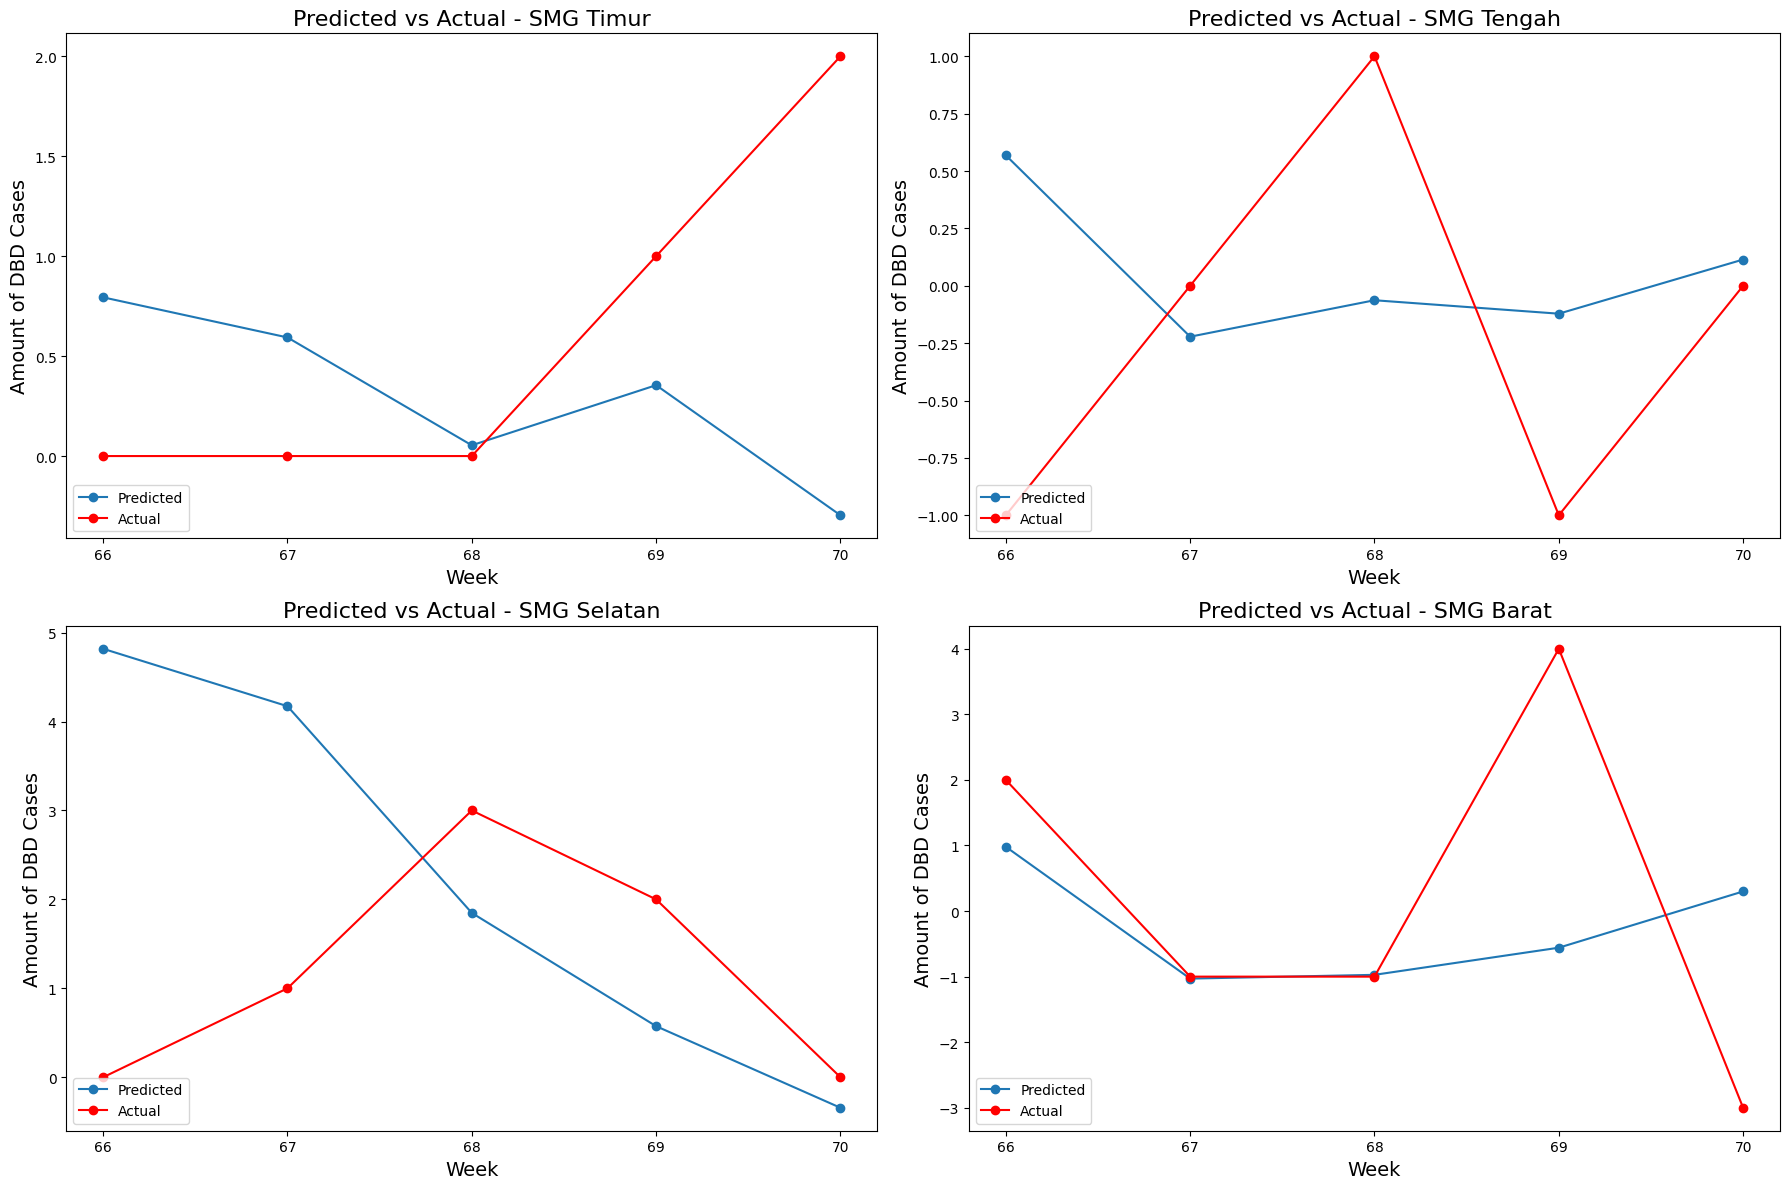

In [ ]:
plt.rcParams["figure.figsize"] = (18, 12)
figure, axis = plt.subplots(2, 2)


# Helper function to plot each subplot
def plot_subplot(ax, forecast_data, actual_data, row_idx):
    n = len(forecast_data)
    weeks = np.arange(data_train.shape[1]+1, data_train.shape[1] + n+1)

    ax.plot(weeks, forecast_data, marker='o', label='Predicted')
    ax.plot(weeks, actual_data, marker='o', label='Actual', c='red')
    ax.set_title(f'Predicted vs Actual - {data.iloc[row_idx, 0]}', fontsize=16)
    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Amount of DBD Cases', fontsize=14)
    ax.set_xticks(weeks)
    ax.legend(loc='lower left')

# Plot each subplot
plot_subplot(axis[0][0], forecast[12], np.array(data_testing)[12], 12)
plot_subplot(axis[0][1], forecast[11], np.array(data_testing)[11], 11)
plot_subplot(axis[1][0], forecast[10], np.array(data_testing)[10], 10)
plot_subplot(axis[1][1], forecast[9], np.array(data_testing)[9], 9)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()